In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import mode

matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

%matplotlib inline

from hbtp import HBTReader
from src.prof import HBTProfileReader
from src.cmh import HBTHistoryReader
from src import read
from src import cosmology
from src import nfw
from src import einasto

### Analysis parameters

In [2]:
grav = "GR_b64n512"
prof = "nfw"
snap = 122
NFW_f = 0.02
nbins = 20
bin = 15
r = HBTReader("./data/%s/subcat" % grav)
prof_reader = HBTProfileReader("./data/%s/subcat" % grav)
hist_reader = HBTHistoryReader("./data/%s/subcat" % grav)

### Subhalo mass function

In [3]:
def subhalo_mass_function(r, snap):
    ss = r.LoadSubhalos(snap)
    ss = ss[(ss['HostHaloId'] != -1) & (ss['BoundM200Crit'] > 0.0)& (ss['Nbound'] >= 20)]

    counts, bin_edges = np.histogram(np.log10(ss['Nbound']), 20)
    ss = np.lib.recfunctions.append_fields(ss, 'bin',\
        np.digitize(np.log10(ss['BoundM200Crit']), bin_edges),\
        usemask=False)
    bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
    return bins, np.log10(counts)

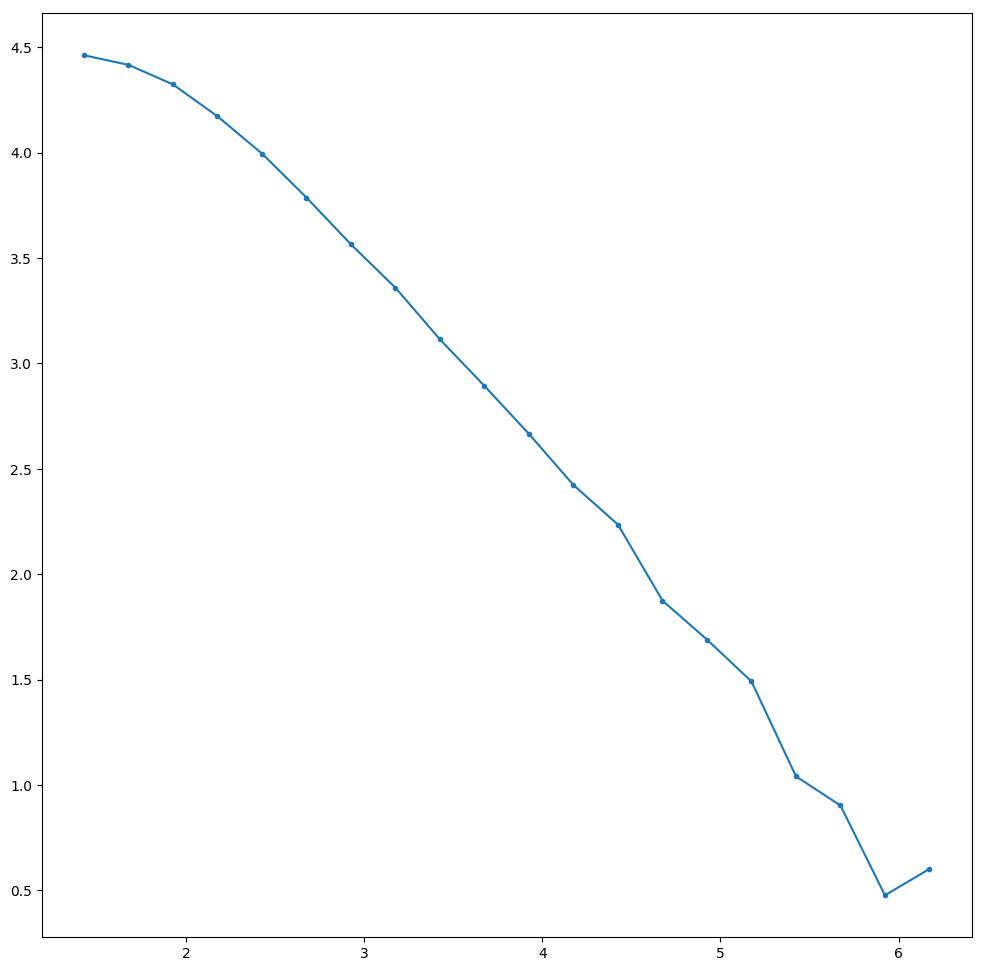

In [4]:
plt.plot(*subhalo_mass_function(r, snap), color='C0', marker='.')

### Halo mass function

Create a histogram to contain all FoF haloes, and use the bins to digitize the `M200Crit` field.

In [5]:
def read_haloes(r, snap):
    hs = r.LoadHostHalos(snap)[['HaloId','R200CritComoving','M200Crit']]
    # hs = hs[(hs['M200Crit'] >= 20) & (hs['CenterOffset'] >= 0.1)]
    hs = hs[hs['M200Crit'] >= 20]
    hs['M200Crit'] = 1e10*hs['M200Crit']
    return hs
    
def bin_haloes(haloes, bin_column, bin_edges, transform=lambda x: x):
    hs = np.lib.recfunctions.append_fields(haloes, 'bin',\
        np.digitize(transform(haloes[bin_column]), bin_edges),\
        usemask=False)
    return hs

def halo_mass_function(r, snap, nbins):
    hs = read_haloes(r, snap)
    counts, bin_edges = np.histogram(np.log10(hs['M200Crit']), nbins)
    hs = bin_haloes(hs, 'M200Crit', bin_edges, lambda x: np.log10(x))
    bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
    return bins, np.log10(counts)

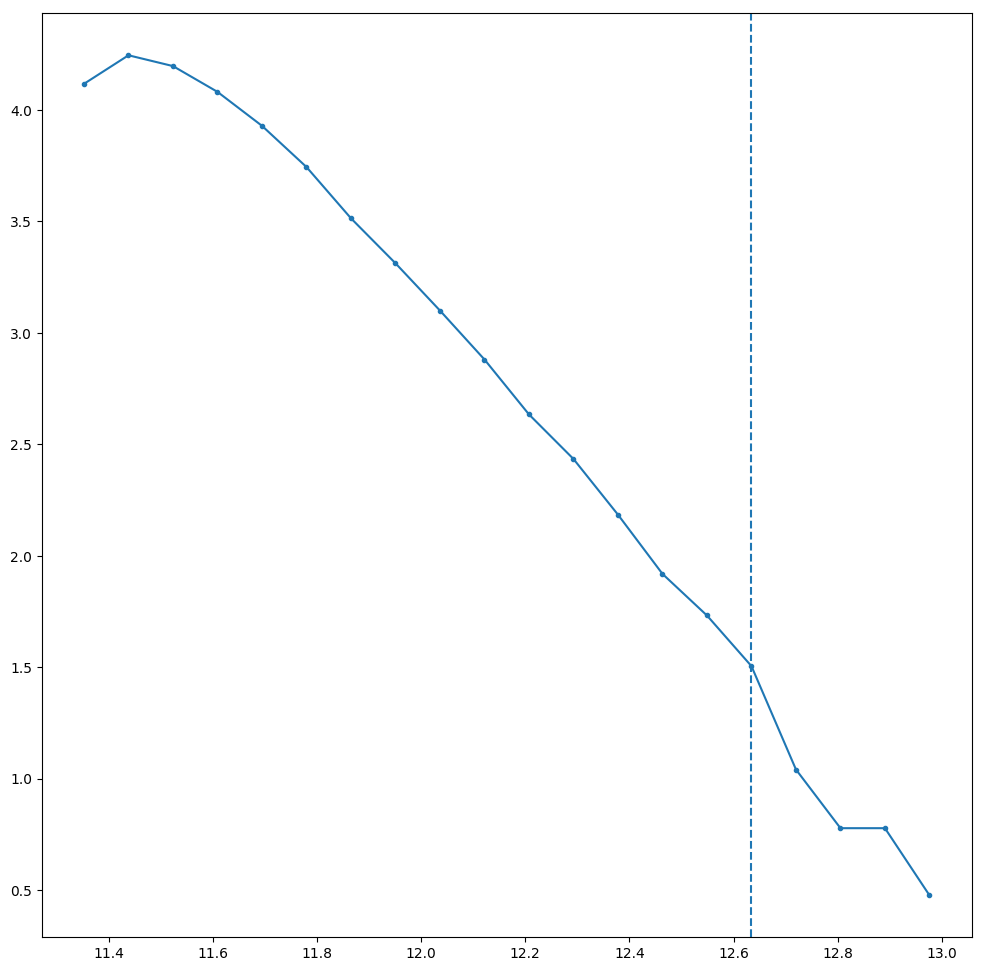

In [6]:
plt.axvline(halo_mass_function(r, snap, nbins)[0][bin], color='C0', linestyle='--')
plt.plot(*halo_mass_function(r, snap, nbins), color='C0', marker='.')

### Binning

In [7]:
hs = read_haloes(r, snap)
_, bin_edges = np.histogram(np.log10(hs['M200Crit']), nbins)
hs = bin_haloes(hs, 'M200Crit', bin_edges, lambda x: np.log10(x))
hs = hs[hs['bin'] == bin]

### Screening

In [8]:
dnf = pd.read_csv("./output/env.%s.%03d.csv" % (grav, snap))["D_Nf"].loc[hs['HaloId']]

/cosma/home/dp004/dc-oles1/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


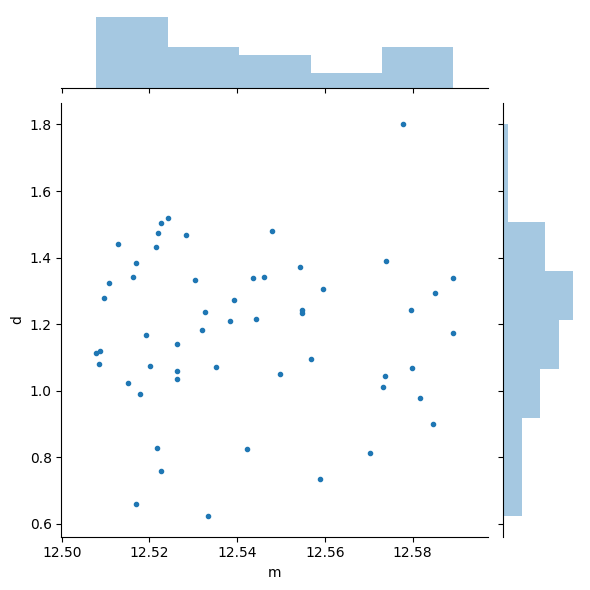

In [9]:
sns.jointplot(x="m", y="d", data=pd.DataFrame({
    'm': np.log10(hs['M200Crit']),
    'd': np.log10(dnf),
}), marker='.', stat_func=None)

### Density profile

In [10]:
def read_profiles(ids, snap=snap):
    return np.array(prof_reader.GetHostProfile([list(hs['HaloId']),], snap), dtype=float)

In [11]:
def halo_profiles(r, ids, prof):
    ps = read_profiles(ids)
    xmin = 0.5 * np.cbrt((4.0 * np.pi)/(3.0 * np.sum(np.mean(ps, axis=0))))
    ps = np.divide(ps.T, np.sum(ps, axis=1)).T
    x = np.linspace(-2.0, 0.0, 20)
    # vol = np.diff(np.power(np.append([0.0], np.power(10.0, x)), 3.0))
    xmax = 0.8
    idx = np.where((np.power(10, x) < xmax) & (np.power(10, x) > xmin))
    
    if prof == 'nfw':

        def f(x, c):
            return np.log10(nfw.m(np.power(10.0, x), c))

        fit = curve_fit(
         f,
         x[idx],
         np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx],
        )
        c = fit[0][0]

        rho_s = np.log10(nfw.rho_enc(1.0/c, c))

        return np.log10(ps), x, np.log10(np.median(ps, axis=0)), idx, rho_s, c

    elif prof == 'einasto':

        def f(x, c, a):
            return np.log10(einasto.m(np.power(10.0, x), c, a))

        fit = curve_fit(
         f,
         x[idx],
         np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx],
        )
        c, a = fit[0][0], fit[0][1]

        rho_s = np.log10(einasto.rho_enc(1.0/c, c, a))

        return np.log10(ps), x, np.log10(np.median(ps, axis=0)), idx, rho_s, c, a

    else:
        raise ValueError("Profile must be either 'nfw' or 'einasto'")

c = halo_profiles(prof_reader, hs['HaloId'], prof)[5]

INFO:root:Retrieving profile for halos [[49, 55, 56, 57, 59, 60, 61, 63, 64, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 111, 112, 114, 115, 119, 120, 122, 126]]


In [12]:
c

6.919211576870957

INFO:root:Retrieving profile for halos [[49, 55, 56, 57, 59, 60, 61, 63, 64, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 111, 112, 114, 115, 119, 120, 122, 126]]


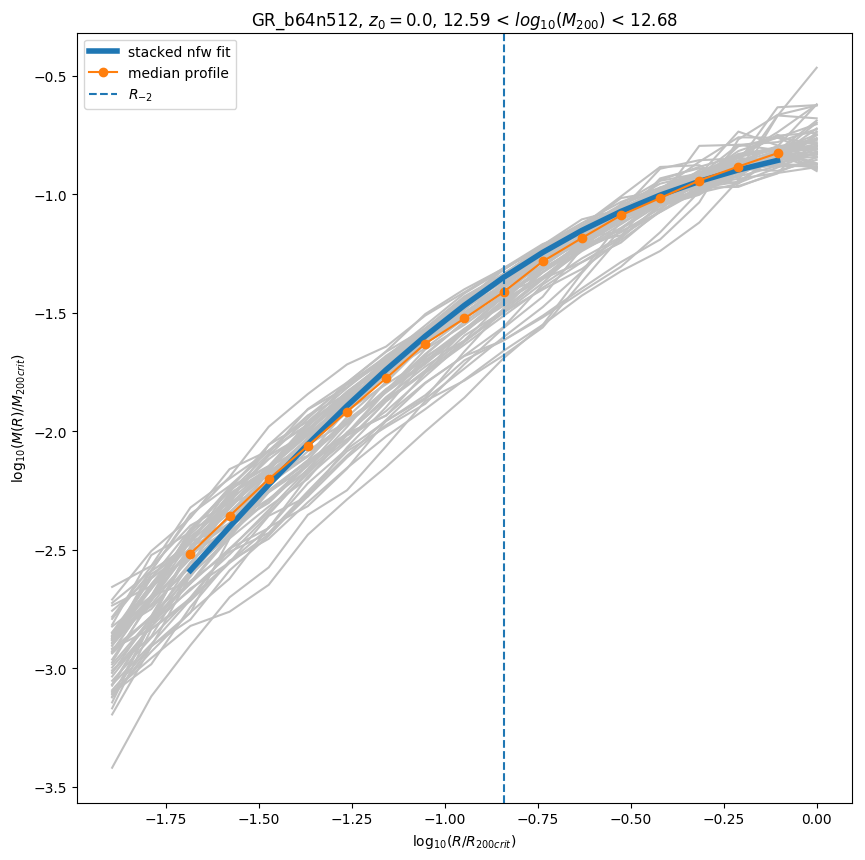

In [13]:
def plot_halo_profiles(ax, prof, *args):
    if prof == 'nfw':
        ps, x, p, idx, rho_s, c = args
    elif prof == 'einasto':
        ps, x, p, idx, rho_s, c, a = args
    else:
        raise ValueError("Profile must be either 'nfw' or 'einasto'")
        
#     s1 = np.percentile(ps, 32.0, axis=0)
#     s2 = np.percentile(ps, 68.0, axis=0)

    ax.plot(x[idx], np.log10(nfw.m_diff(np.power(10.,x), c)[idx]),
        color='C0', linestyle='-', linewidth=4, zorder=2, label='stacked %s fit' % prof)

#     ax.plot(x[idx], np.log10(nfw.m_diff(np.power(10.,x), 7.943282347242816)[idx]),
#         color='C3', linestyle='--', linewidth=4, zorder=2, label='c-m prediction')

    [ax.plot(x[1:], _[1:], color='silver', zorder=0) for _ in ps]
    ax.plot(x[idx], p[idx], color='C1', marker='o', zorder=2, label='median profile')
    ax.axvline(np.log10(1.0/c), color='C0', linestyle='--', label='$R_{-2}$')

    ax.legend()

fig, ax = plt.subplots(1, figsize=(10, 10))
ax.set_title("%s, $z_0=0.0$, %.2f < $log_{10}(M_{200})$ < %.2f" %
             (grav, bin_edges[bin], bin_edges[bin+1]))
ax.set_xlabel(r"$\log_{10}(R / R_{200 crit})$")
ax.set_ylabel(r"$\log_{10}(M(R) / M_{200 crit})$")
plot_halo_profiles(ax, prof, *halo_profiles(prof_reader, hs['HaloId'], prof))

# fig.savefig("./fig_prof.pdf")

### Collapsed Mass History

In [14]:
def F(profile, *args):
    if profile == 'nfw':
        c = args[0]
        return nfw.m(1.0/c, c)
    elif profile == 'einasto':
        c, a = args
        return einasto.m(1.0/c, c, a)
    else:
        raise ValueError("Profile must be either 'nfw' or 'einasto'")

In [15]:
def halo_mass_history(grav, snap, hs, F):
    ms = np.array(
        pd.read_csv("./output/cmh.f%03d.%s.%03d.csv" % (100 * NFW_f, grav, snap))\
            .set_index('HostHaloId')\
            .fillna(0.0)\
            .loc[hs['HaloId']]\
            .dropna(),
        dtype=float
    )
    ms = np.divide(ms.T, ms[:,-1]).T
    m = np.median(ms, axis=0)

    zs = read.snaps()
    rho = cosmology.rho_c(
        np.array([
            zs[zs['Snapshot'] == s][0]['Redshift']
            for s in np.arange(1+snap-ms.shape[1], 1+snap)
        ])) / \
        cosmology.rho_c(zs[zs['Snapshot'] == snap][0]['Redshift'])

    m_f = F*m[-1]
    y1, y2 = m[m > m_f][0], m[m < m_f][-1]
    x1, x2 = rho[m > m_f][0], rho[m < m_f][-1]
    rho_f = (np.log10(x1/x2)/np.log10(y1/y2))*(np.log10(m_f/y1))+np.log10(x1)

    return ms, rho, m, rho_f

In [16]:
F(prof, c)

0.1615528070899597

/cosma/home/dp004/dc-oles1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/cosma/home/dp004/dc-oles1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


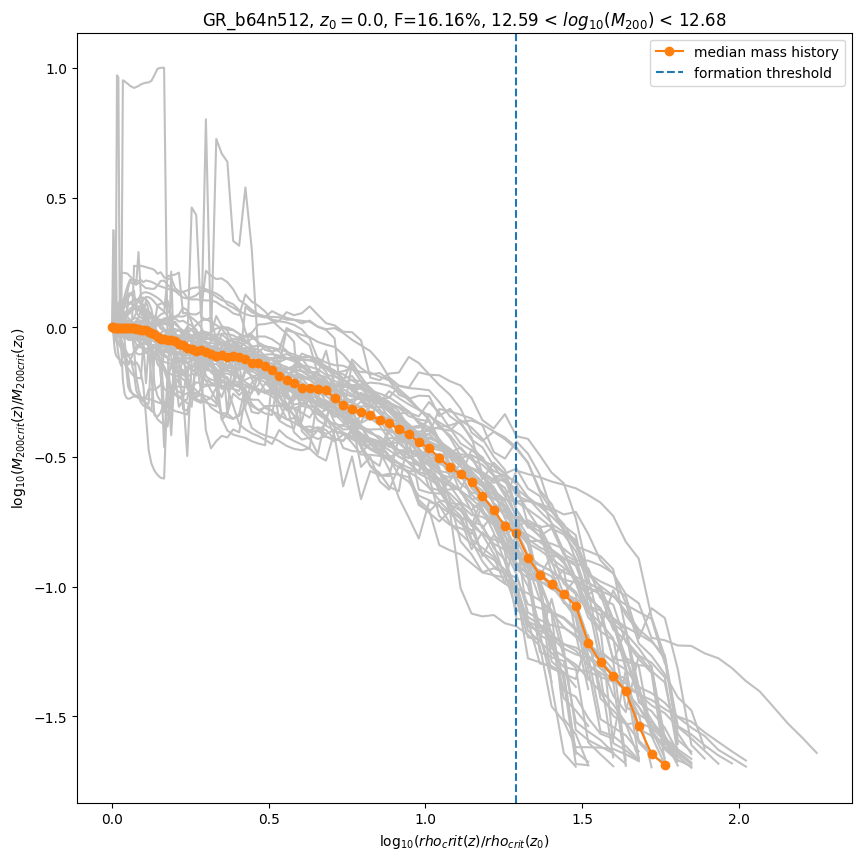

In [17]:
def plot_halo_mass_history(ax, *args):
    ms, rho, m, rho_f = args
    [ax.plot(np.log10(rho), np.log10(_), color='silver') for _ in ms]
    ax.plot(np.log10(rho), np.log10(m), color='C1', marker='o', label='median mass history')
    ax.axvline(rho_f, color='C0', linestyle='--', label='formation threshold')
    ax.legend()

fig, ax = plt.subplots(1, figsize=(10, 10))
ax.set_title("%s, $z_0=0.0$, F=%.2f%%, %.2f < $log_{10}(M_{200})$ < %.2f" %
             (grav, 100.0*F(prof, c), bin_edges[bin], bin_edges[bin+1]))
ax.set_xlabel(r"$\log_{10}(rho_crit(z) / rho_{crit}(z_0)$")
ax.set_ylabel(r"$\log_{10}(M_{200 crit}(z) / M_{200 crit}(z_0)$")
plot_halo_mass_history(ax, *halo_mass_history(grav, snap, hs, F(prof, c)))

# fig.savefig("./fig_hist.pdf")